In [1]:
# Importing Libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from Lspin import Lspin, DataSetMeta
import matplotlib.colors as colors

In [2]:
def generate_data(N_train=1500, N_valid=300, N_test=300, D=20):
    np.random.seed(42)

    def generate_set(N):
        group_size = int(N / 3)
        X = np.sign(np.random.normal(0, 1, (N, D)))
        X = np.concatenate((X, np.concatenate(([-1]*group_size, [0]*group_size, [1]*group_size)).reshape(-1, 1)), axis=1)
        Y = np.concatenate((
            X[:group_size, 0] * X[:group_size, 1] + 2 * X[:group_size, -1],
            X[group_size:(group_size*2), 1] * X[group_size:(group_size*2), 2] + 2 * X[group_size:(group_size*2), -1],
            X[(group_size*2):(group_size*3), 2] * X[(group_size*2):(group_size*3), 3] + 2 * X[(group_size*2):(group_size*3), -1],
        ), axis=0)
        return X, Y

    # Generate train, validation, and test sets
    X_train, Y_train = generate_set(N_train)
    X_valid, Y_valid = generate_set(N_valid)
    X_test, Y_test = generate_set(N_test)

    # Shuffle the data
    def shuffle_data(X, Y):
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        return X[indices], Y[indices]

    X_train, Y_train = shuffle_data(X_train, Y_train)
    X_valid, Y_valid = shuffle_data(X_valid, Y_valid)
    X_test, Y_test = shuffle_data(X_test, Y_test)

    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

In [3]:
# Generate the data
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = generate_data()

# Print shapes to verify
print("Train shapes:", X_train.shape, Y_train.shape)
print("Validation shapes:", X_valid.shape, Y_valid.shape)
print("Test shapes:", X_test.shape, Y_test.shape)

# Create PyTorch datasets
train_dataset = DataSetMeta(X_train, Y_train, Y_train)
valid_dataset = DataSetMeta(X_valid, Y_valid, Y_valid)
test_dataset = DataSetMeta(X_test, Y_test, Y_test)

Train shapes: (1500, 21) (1500,)
Validation shapes: (300, 21) (300,)
Test shapes: (300, 21) (300,)


In [4]:
# Model parameters
model_params = {
    'input_node': X_train.shape[1],
    'hidden_layers_node': [500, 100, 1],
    'output_node': 1,
    'gating_net_hidden_layers_node': [100],
    'display_step': 100,
    'activation_gating': 'tanh',
    'activation_pred': 'l_relu',
    'lam': 1,
    'sigma': 0.5,
    'a': 1,
    'gamma1': 0,
    'gamma2': 0,
    'num_meta_label': None,
    'stddev_input': 0.1,
    'stddev_input_gates': 0.1,
    'seed': 42,
    'val': True  # Enabling validation during training
}

# Training parameters
training_params = {
    'batch_size': 64,
    'num_epochs': 5000,  # Increased number of epochs
    'lr': 0.001,  # Adjusted learning rate
    'compute_sim': False
}

In [5]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Lspin(**model_params).to(device)
# Train the model
train_losses, val_losses, val_acc = model.train_model(
    dataset=train_dataset, 
    valid_dataset=valid_dataset,
    batch_size=training_params['batch_size'], 
    num_epoch=training_params['num_epochs'], 
    lr=training_params['lr'], 
    compute_sim=training_params['compute_sim']
)

c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([44])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/5000], Train Loss: 2.2207, Validation Loss: 5.3310, Validation Acc: -4.3310
Epoch [200/5000], Train Loss: 1.4714, Validation Loss: 6.0134, Validation Acc: -5.0134
Epoch [300/5000], Train Loss: 1.1362, Validation Loss: 6.4703, Validation Acc: -5.4703
Epoch [400/5000], Train Loss: 0.8917, Validation Loss: 6.6599, Validation Acc: -5.6599
Epoch [500/5000], Train Loss: 0.7191, Validation Loss: 6.6750, Validation Acc: -5.6750
Epoch [600/5000], Train Loss: 0.6844, Validation Loss: 6.7213, Validation Acc: -5.7213
Epoch [700/5000], Train Loss: 0.5650, Validation Loss: 6.7647, Validation Acc: -5.7647
Epoch [800/5000], Train Loss: 0.4428, Validation Loss: 6.8324, Validation Acc: -5.8324
Epoch [900/5000], Train Loss: 0.3307, Validation Loss: 6.7263, Validation Acc: -5.7263
Epoch [1000/5000], Train Loss: 0.3072, Validation Loss: 6.9002, Validation Acc: -5.9002
Epoch [1100/5000], Train Loss: 0.2731, Validation Loss: 6.9792, Validation Acc: -5.9792
Epoch [1200/5000], Train Loss: 0.2531, Va

In [6]:
predictions,alpha = model.test(X_test)
print(alpha.max())

3.3866746


Mean Squared Error on the test: 7.73348


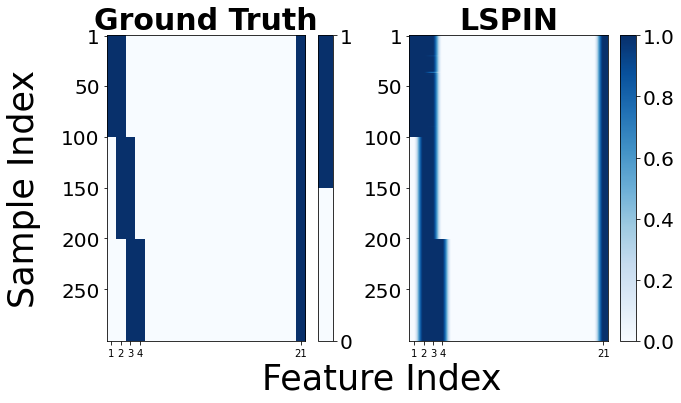

In [7]:
# Test the model
predictions,alpha = model.test(X_test)

# Calculate Mean Squared Error on the test set
mse = np.mean((Y_test - predictions) ** 2)
print("Mean Squared Error on the test: {:.5f}".format(mse))

# Visualizing the gate matrix
gate_matrix_test = model.get_prob_alpha(torch.FloatTensor(X_test).to(device))

# Compare to ground truth
g_test = np.zeros((X_test.shape[0], X_test.shape[1]))
for i in range(g_test.shape[0]):
    if X_test[i, -1] == -1:
        g_test[i, 0] = 1
        g_test[i, 1] = 1
    elif X_test[i, -1] == 0:
        g_test[i, 1] = 1
        g_test[i, 2] = 1
    elif X_test[i, -1] == 1:
        g_test[i, 2] = 1
        g_test[i, 3] = 1
g_test[:, -1] = 1

fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10, 6))

cmap = plt.cm.Blues 
bounds = [0, 0.5, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)
fig.add_subplot(111, frameon=False)

title_size = 30
xlabel_size = 35
ylabel_size = 35
xtick_size = 20
ytick_size = 20
bar_label_size = 20

plt.rc('xtick', labelsize=20)

# Test
y_axis_order = np.argsort(X_test[:, -1])

im5 = axes[0].imshow(g_test[y_axis_order, :], aspect='auto', cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth", fontsize=title_size, fontweight="bold")
axes[0].set_ylabel("Sample Index", fontsize=ylabel_size, labelpad=20)
axes[0].set_xticks([0, 1, 2, 3, 20])
axes[0].set_xticklabels([1, 2, 3, 4, 21])
axes[0].set_yticks([0, 49, 99, 149, 199, 249])
axes[0].set_yticklabels([1, 50, 100, 150, 200, 250], fontsize=ytick_size)

im7 = axes[1].imshow(gate_matrix_test[y_axis_order, :].cpu().numpy(), aspect='auto', cmap=cmap)
axes[1].set_title("LSPIN", fontsize=title_size, fontweight="bold")
axes[1].set_yticks([0, 49, 99, 149, 199, 249])
axes[1].set_yticklabels([1, 50, 100, 150, 200, 250], fontsize=ytick_size)

cbar = fig.colorbar(im5, ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=bar_label_size)

cbar = fig.colorbar(im7, ax=axes[1], cmap=cmap)
cbar.ax.tick_params(labelsize=bar_label_size)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Feature Index", fontsize=xlabel_size)
plt.tight_layout()
plt.show()

In [8]:
print(gate_matrix_test)

tensor([[0., 1., 1.,  ..., 0., 0., 1.],
        [1., 1., 1.,  ..., 0., 0., 1.],
        [1., 1., 1.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 1.,  ..., 0., 0., 1.],
        [1., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 0., 0., 1.]])
